# Background and Business Case

Powerlifting is a weightlifting sport that focuses on 3 movements; squat, bench press, and deadlift. In competitiion lifters will have 3 attempts at each lift. Lifters are split up by weight class and gender. The objective is to lift the most amount of weight. A new event, the Sheffield, is backed by a lot of sponsors has added another complexity to powerlifting. A lifter wins Sheffield by breaking any record by the highest %. However only top ranked lifters get invited.

Meet day is a unique optimzation problem.Each lifter has strengths and weaknesses based on their anatomy. For example a lifter with long legs and arms will be great at deadlifts but struggle with bench. As the lifters approach their theorectical max on each lift, the marginal cost (energy) to lift 1kg increases. So it doesn't make sense to burn up unecessary energy in a weak lift to gain 2.5kg when the same energy could net the lifter 10kg in a strong lift.

An added wrinkle to this is that sometimes the lifters do not know what they are capable of. The training programs they are on force them to train so hard that they feel weak several days before the meet. This is so the body overcompensates and allows them to lift more weight. Beacuse of this coaches typically select a first attempt weight that will allow the lifter to guage what they are capable of.

The business case for this model is to give coaches predictions on what attempts the competition has planned. If a coach can predict what the competitors will do in a meet then they can optimize their lifters attempts to give them the best chance to win the meet. The coaches are generally making decision based on intuition. For the elite group of lifters the object is to win the meet but also to win Sheffield. Sometimes these lifters are making a run to break their own records. So a predictive model will allow them to figure out the minimum total needed to win. This leaves room for the lifter to break the record by a larger margin.

The objective is to develop a model that can predict a lifters next attempt and to predict their overall total based on that attempt and previous attempts.The goal would be to get the attempt predictions within 2.5kg. A good goal for the total prediction model would be within 10kg on the 2nd squat attempt.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

Import data and filter for IPF sanctioned meets that are raw tested SBD meets. The IPF is the largest worldwide federation. It has rigorous drug testing and well defined rules. There are different types of powerlifting meets. SBD are the typical full meets. Raw means there is no equipment allowed. Sanctioned means that it was an official meet and not some casual get together.

In [ ]:
data = pd.read_csv('/content/openipf-2025-05-03-c77c7449.csv', delimiter=',')


<ipython-input-4-12b3dde89678>:1: DtypeWarning: Columns (33,38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/openipf-2025-05-03-c77c7449.csv', delimiter=',')


In [ ]:
data = data[data['Event'] == 'SBD']
data = data[data['Equipment'] == 'Raw']
data = data[data['Tested'] == 'Yes']
data = data[data['Sanctioned'] == 'Yes']

# EDA

In [ ]:
data.head(10)

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName,Sanctioned
0,Amy Clair,F,SBD,Raw,36.0,35-39,24-39,Open,75.54,76,...,Australia,NaN,APLA,IPF,2024-10-20,Australia,SA,NaN,AUPC Powerlifting Open,Yes
1,Ruby Olthoff,F,SBD,Raw,17.0,16-17,14-18,Sub-Junior,69.44,76,...,Australia,NaN,APLA,IPF,2024-10-20,Australia,SA,NaN,AUPC Powerlifting Open,Yes
2,Wai Hang Wong,M,SBD,Raw,21.0,20-23,19-23,Junior,70.64,74,...,Australia,NaN,APLA,IPF,2024-10-20,Australia,SA,NaN,AUPC Powerlifting Open,Yes
3,Jonathan Chan #2,M,SBD,Raw,23.0,20-23,19-23,Junior,81.34,83,...,Australia,NaN,APLA,IPF,2024-10-20,Australia,SA,NaN,AUPC Powerlifting Open,Yes
4,Sung Hoon Ok,M,SBD,Raw,22.0,20-23,19-23,Junior,92.42,93,...,Australia,NaN,APLA,IPF,2024-10-20,Australia,SA,NaN,AUPC Powerlifting Open,Yes
5,Jaek Coleman,M,SBD,Raw,23.0,20-23,19-23,Junior,87.40,93,...,Australia,NaN,APLA,IPF,2024-10-20,Australia,SA,NaN,AUPC Powerlifting Open,Yes
6,Milan Grdosic,M,SBD,Raw,22.0,20-23,19-23,Junior,102.40,105,...,Australia,NaN,APLA,IPF,2024-10-20,Australia,SA,NaN,AUPC Powerlifting Open,Yes
7,Yao Alexandre Kpade,M,SBD,Raw,19.0,18-19,19-23,Junior,97.42,105,...,Australia,NaN,APLA,IPF,2024-10-20,Australia,SA,NaN,AUPC Powerlifting Open,Yes
8,John Holland,M,SBD,Raw,76.0,75-79,70-999,Masters 4,91.26,93,...,Australia,NaN,APLA,IPF,2024-10-20,Australia,SA,NaN,AUPC Powerlifting Open,Yes
9,Paul Leikas,M,SBD,Raw,28.0,24-34,24-39,Special Olympics,65.84,66,...,Australia,NaN,APLA,IPF,2024-10-20,Australia,SA,NaN,AUPC Powerlifting Open,Yes


In [ ]:
data.shape

(519106, 42)

In [ ]:
#distinct lifters
print(data['Name'].nunique())

201045


In [ ]:
data.isnull().sum()

,0
Name,0
Sex,0
Event,0
Equipment,0
Age,96667
AgeClass,82519
BirthYearClass,73629
Division,0
BodyweightKg,1047
WeightClassKg,3639


In [ ]:
data['Sex'].value_counts()
#drop Mx

,count
Sex,
M,349888
F,169213
Mx,5


In [ ]:
#dropping gender neutral lfiters
data =data[data['Sex'] != 'Mx']

In [ ]:
best_lifts = data[['Best3SquatKg','Best3BenchKg','Best3DeadliftKg']].dropna()
failed_lifts = (data[['Best3SquatKg','Best3BenchKg','Best3DeadliftKg']] < 0).any(axis=1)
best_lifts = best_lifts[~failed_lifts]

<ipython-input-7-409d0165d426>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_lifts = best_lifts[~failed_lifts]


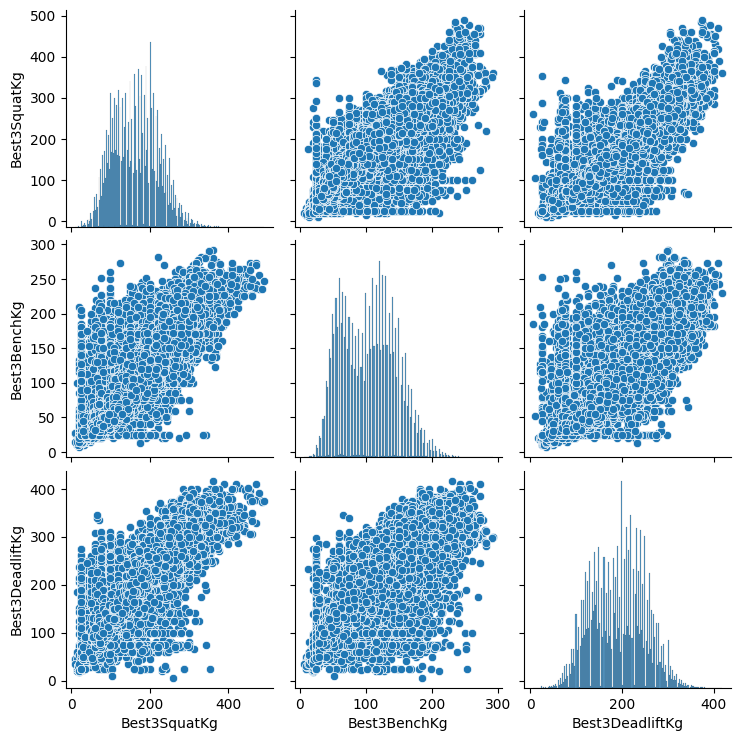

In [ ]:
#pair plot with male and female lifters - the two distributions are visibile
sns.pairplot(best_lifts)
plt.show()

<ipython-input-9-ba8491517446>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_lifts = best_lifts[data['Sex'] == 'M']
<ipython-input-9-ba8491517446>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_lifts = best_lifts[data['Sex'] == 'F']


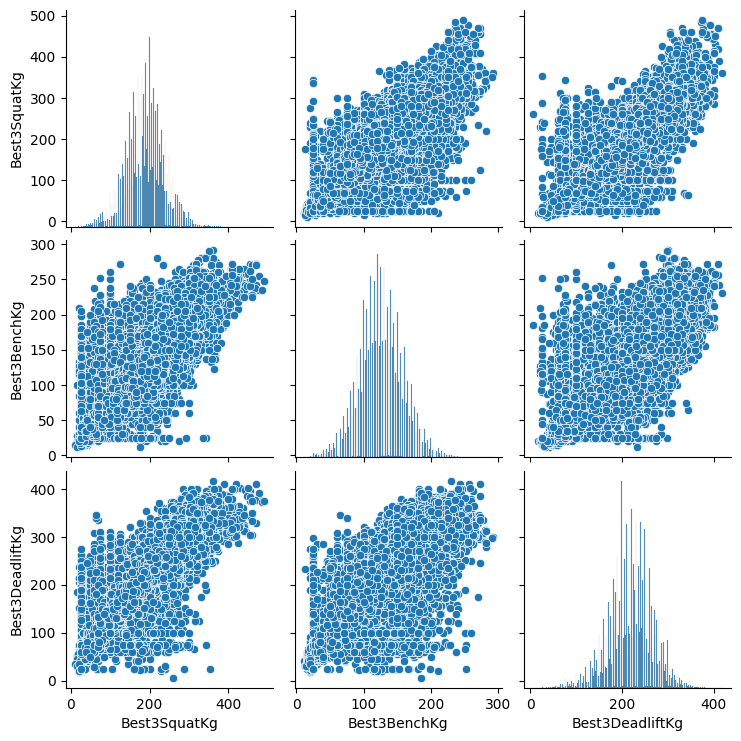

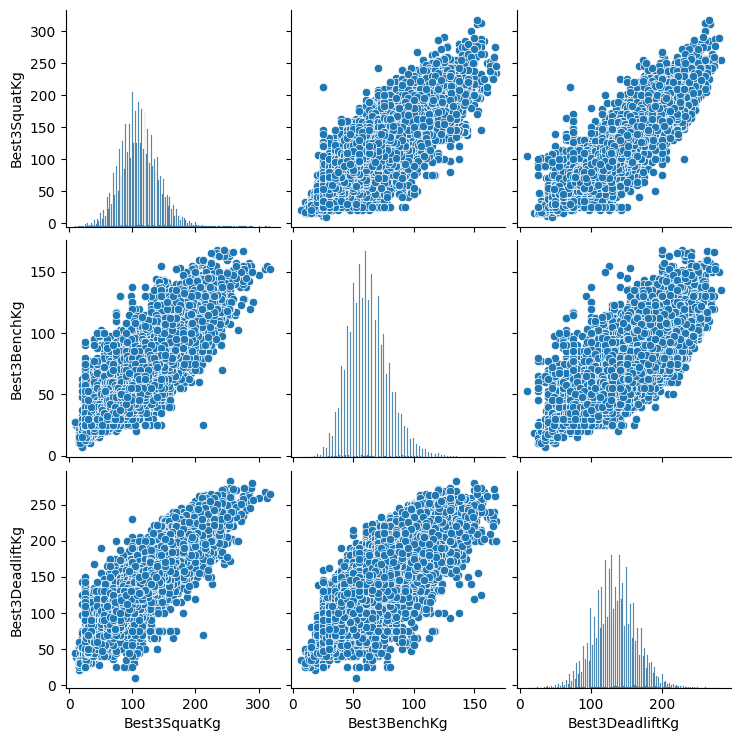

In [ ]:
#seperate by gender
male_lifts = best_lifts[data['Sex'] == 'M']
female_lifts = best_lifts[data['Sex'] == 'F']
sns.pairplot(male_lifts)
plt.show()
sns.pairplot(female_lifts)
plt.show()

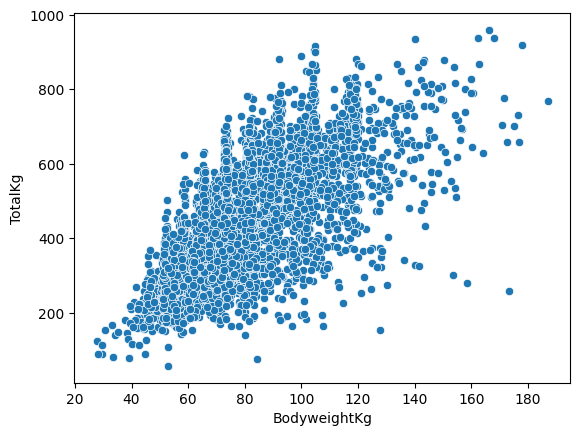

In [ ]:
#relationship between weight and total
sample_df = data.sample(5000, random_state=1)
weight_total = sample_df[['BodyweightKg','TotalKg']].dropna()
sns.scatterplot(data=weight_total, x='BodyweightKg', y='TotalKg')
plt.show()

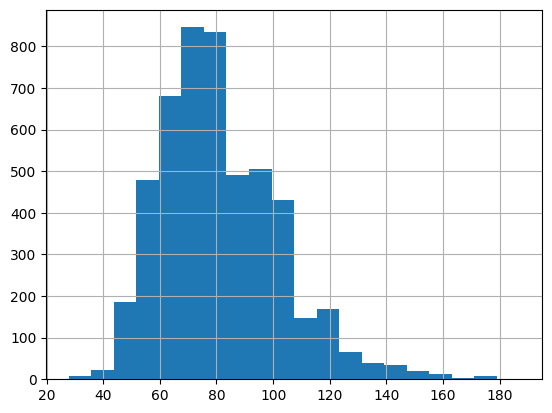

In [ ]:
#histrogram of bodyweights
sample_df['BodyweightKg'].hist(bins=20)
plt.show()

It makes sense that as one lift increases, the other 2 as well. The lifts are considered full body lifts. So no muscle is acting in isolation. The distribution of each lift appears to be normal. As bodyweight increases so does a lifters total. More weight means more muscular tissue which means more capacity to lift. I will be using bodyweight as a feature instead of weightclass. Weightclasses are different between genders and there is more data missing. The distribution of bodyweight is skewed to the right but that is expected. There is no upper bound in the heavyweight weight class. However there is a lighest weight class and minimum weights for a healthy adult.

I do not see any outliers that need to be adressed. This does not surprise me either. Sanctioned meets are organized and the results being accurately reported has implications for their career. Open powerlifting does have quality controls in place when loading data as well.

I am surpised by the amount of missing values for bodyweight. That is an important aspect of a powerlifting meet. However there are so many records that I am not concerned about dropping those records.

I am worried about the number of unique names. It is data form around the world so its possible it is accurate. Open Powerlifting assigns a number to lifters that have duplicate names but are different people. Tackling this will be very difficult and so I will proceed assuming that the names are accurate.

Based on my experience and knowledge of the sport, lifters attempts will be dependent on their anatony. Some lifters are easier for them than others. This data set unfortunately does not have this so I will use clustering to try to group lifters that have similar lifting splits.

To prevent dataleakage I am going to use lifters with only 1 recorded meet to create the clusters. Lifters with multiple meets will have their first meet used to put them in a cluster. This meet will be removed from the training set.

I am okay with removing lifters with only one recorded meet. The business case for this model is for athletes at the elite world level. To get to these meets you had to have competed before. So in the real world the data would be avaialble to cluster a new competitor.

In [ ]:
#calculate number of lifters that have X number of meets in the dataset
meet_value_counts = data['Name'].value_counts().value_counts()
meet_value_counts

,count
count,
1,99022
2,40497
3,20628
4,12589
5,8140
6,5486
7,3719
8,2666
9,1912


There is enough data to proceed

In [ ]:
name_counts = data['Name'].value_counts()
single_meet_lifters = data[data['Name'].isin(name_counts[name_counts == 1].index)]
single_meet_lifters_list = single_meet_lifters['Name'].tolist()

In [ ]:
single_meet_df = data[data['Name'].isin(single_meet_lifters_list)]

In [ ]:
#clean and prep data for clustering

In [ ]:
def clustering_prep(df):
  lift_attempts_col = ['Squat1Kg','Squat2Kg','Squat3Kg','Bench1Kg','Bench2Kg','Bench3Kg','Deadlift1Kg','Deadlift2Kg','Deadlift3Kg']
  #find best lifts across all attempts in case top lift attempt is missing
  df[lift_attempts_col].fillna(0,inplace=True)
  df['TopSquatKg'] = df[['Squat1Kg','Squat2Kg','Squat3Kg']].max(axis=1)
  df['TopBenchKg'] = df[['Bench1Kg','Bench2Kg','Bench3Kg']].max(axis=1)
  df['TopDeadliftKg'] = df[['Deadlift1Kg','Deadlift2Kg','Deadlift3Kg']].max(axis=1)

  df['Best3SquatKg'] = df['Best3SquatKg'].fillna(df['TopSquatKg'])
  df['Best3BenchKg'] = df['Best3BenchKg'].fillna(df['TopBenchKg'])
  df['Best3DeadliftKg'] = df['Best3DeadliftKg'].fillna(df['TopDeadliftKg'])

  #drop lifters that are missing attempts or lifts
  df.dropna(subset=['Best3SquatKg','Best3BenchKg','Best3DeadliftKg'],inplace=True)
  #Im going to give the lifters the benefit of the doubt for failed lifts. The weight they attempted is most likely close to their max
  df['Best3SquatKg'] = df['Best3SquatKg'].abs()
  df['Best3BenchKg'] = df['Best3BenchKg'].abs()
  df['Best3DeadliftKg'] = df['Best3DeadliftKg'].abs()

  #calculate total
  df['ClustingTotal'] = df['Best3SquatKg'] + df['Best3BenchKg'] + df['Best3DeadliftKg']
  #make % based
  df['SquatPct'] = df['Best3SquatKg'] / df['ClustingTotal']
  df['BenchPct'] = df['Best3BenchKg'] / df['ClustingTotal']
  df['DeadliftPct'] = df['Best3DeadliftKg'] / df['ClustingTotal']


  #check to make sure its normally distributed
  df['SquatPct'].hist(bins=20)
  plt.show()
  df['BenchPct'].hist(bins=20)
  plt.show()
  df['DeadliftPct'].hist(bins=20)
  plt.show()

  c_array = df[['SquatPct','BenchPct','DeadliftPct']].values

  return df, c_array


<ipython-input-46-2aa6cc856d55>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lift_attempts_col].fillna(0,inplace=True)
<ipython-input-46-2aa6cc856d55>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TopSquatKg'] = df[['Squat1Kg','Squat2Kg','Squat3Kg']].max(axis=1)
<ipython-input-46-2aa6cc856d55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

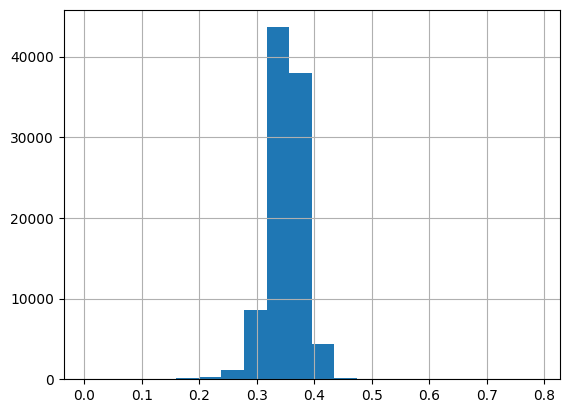

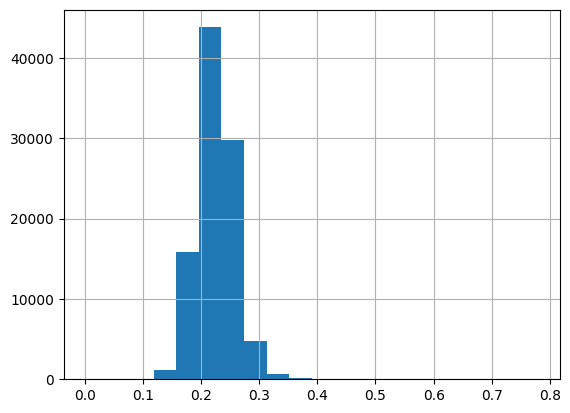

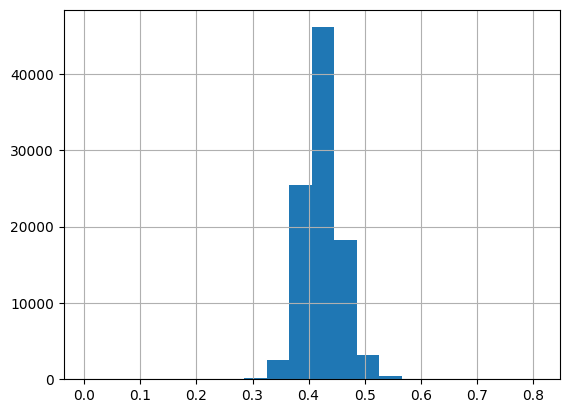

In [ ]:
clustering_df,clustering_values = clustering_prep(single_meet_df)

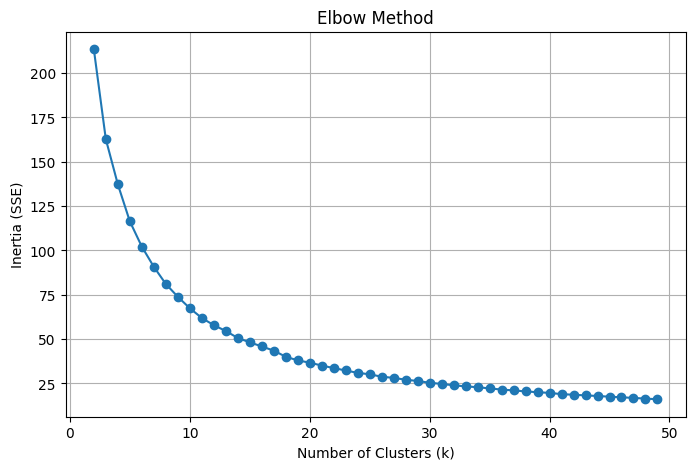

In [ ]:
inertia_values = []
k_range = range(2, 50) # I suspect that that the optimal number of bins will be between 3 and 7

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(clustering_values)
    inertia_values.append(kmeans.inertia_)




plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method')
plt.grid()
plt.show()


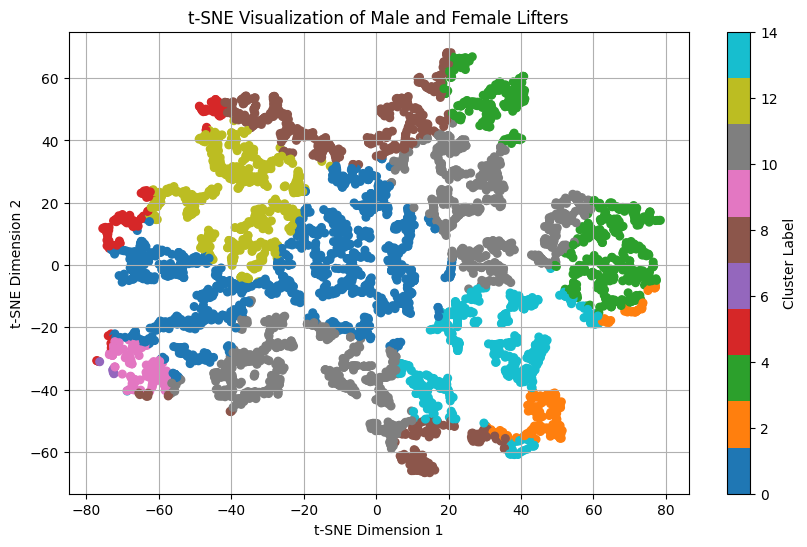

In [ ]:
final_kmeans = KMeans(n_clusters=15, random_state=1)
final_kmeans.fit(clustering_values)
clusters = final_kmeans.labels_

sample_size = 5000
random_indices = np.random.choice(clustering_values.shape[0], sample_size, replace=False)
sampled = clustering_values[random_indices]
sampled_labels = clusters[random_indices]


tsne = TSNE(n_components=2, random_state=1)
X_embedded = tsne.fit_transform(sampled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=sampled_labels, cmap='tab10', s=30)
plt.colorbar(scatter, label="Cluster Label")
plt.title('t-SNE Visualization of Male and Female Lifters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid()
plt.show()

I am surprised that the number of clusters recommended by the elbow method was 15. It is more than I expected. In my head I think about lifters as either being specialized in one lift, good in 2 lifts and bad in the other, or a generalist. Some clusters only have a few hundred lifters in them. This could be a problem as I filter down datasets for modeling and split datasets.

I grouped male and female lifters together. From my own experience both genders are capable of being specialists in any lift. It is also interesting to be able to compare lifters in different genders.

In [ ]:
clustering_df['Cluster'] = final_kmeans.labels_

<ipython-input-34-b7b12c322d62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_df['Cluster'] = final_kmeans.labels_


In [ ]:
clustering_df['Cluster'].value_counts()

,count
Cluster,
0,14513
11,11450
12,10410
14,10282
10,9706
7,8261
1,8096
3,6630
4,4725


Now fit the K-Means to liters that have more than one meet. Im going to use their first meets

In [ ]:
#dataframe with lifters with more than one meet
exp_df = data[~data['Name'].isin(single_meet_lifters_list)]

In [ ]:
first_meets = exp_df.loc[exp_df.groupby('Name')['Date'].idxmin()]

<ipython-input-46-2aa6cc856d55>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lift_attempts_col].fillna(0,inplace=True)


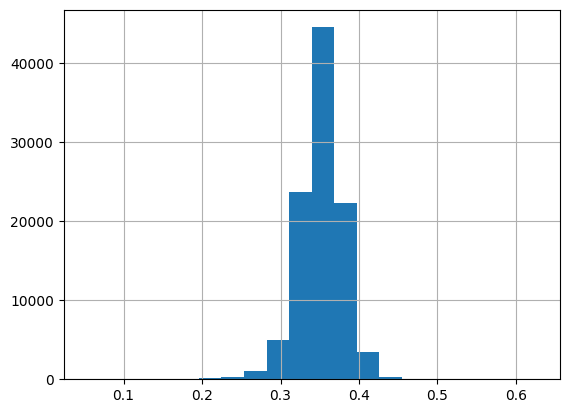

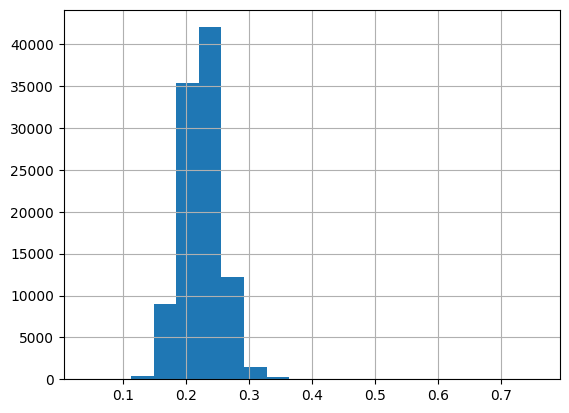

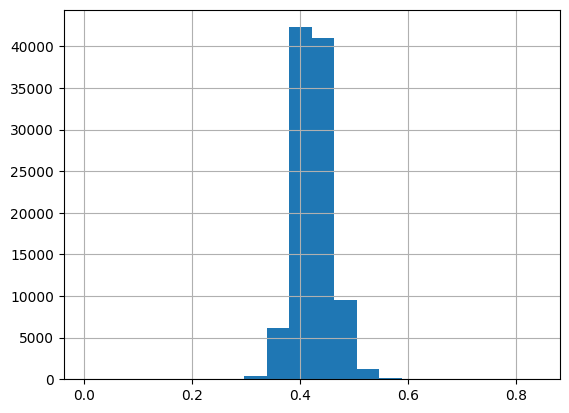

In [ ]:
first_meets,clustering_value_exp = clustering_prep(first_meets)

The % of each lift to the total look normal so I feel okay with using K-Means. If these were not normal I would need to consider DBSCAN

In [ ]:
exp_clusters = final_kmeans.predict(clustering_value_exp)

In [ ]:
first_meets['Cluster'] = exp_clusters

In [ ]:
#remove those first meets
modeling_df = exp_df.drop(first_meets.index)

In [ ]:
#join the first_meets to the modeling_df to get the cluster
modeling_df = modeling_df.join(first_meets[['Name','Cluster']].set_index('Name'),on='Name',how='left')
len(modeling_df)

319116

In [ ]:
modeling_df.dropna(subset=['Cluster'], inplace=True)

In [ ]:
len(modeling_df)

315172

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the CSV file in your Google Drive
# You can change 'My Drive/your_folder/modeling_df.csv' to your desired location and filename
save_path = '/content/drive/My Drive/modeling_df.csv'

# Save the DataFrame to CSV
modeling_df.to_csv(save_path, index=False) # index=False prevents writing the DataFrame index as a column

print(f"DataFrame successfully saved to {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame successfully saved to /content/drive/My Drive/modeling_df.csv
